In [1]:
import pandas as pd
import os
import numpy as np

In [2]:
data_path='dataset'
categories=os.listdir(data_path)
labels=[i for i in range(len(categories))]

label_dict=dict(zip(categories,labels)) #empty dictionary

print(label_dict)
print(categories)
print(labels)

{'Covid19 Negative': 0, 'Covid19 Positive': 1}
['Covid19 Negative', 'Covid19 Positive']
[0, 1]


In [3]:
import cv2
img_size=100
data=[]
target=[]


for category in categories:
    folder_path=os.path.join(data_path,category)
    img_names=os.listdir(folder_path)
        
    for img_name in img_names:
        img_path=os.path.join(folder_path,img_name)
        img=cv2.imread(img_path)

        try:
            gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)           
            #Coverting the image into gray scale
            resized=cv2.resize(gray,(img_size,img_size))
            #resizing the gray scale into 100x100, since we need a fixed common size for all the images in the dataset
            data.append(resized)
            target.append(label_dict[category])
            #appending the image and the label(categorized) into the list (dataset)

        except Exception as e:
            print('Exception:',e)
            #if any exception rasied, the exception will be printed here. And pass to the next image

Exception: OpenCV(4.5.4-dev) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'

Exception: OpenCV(4.5.4-dev) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'

Exception: OpenCV(4.5.4-dev) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'

Exception: OpenCV(4.5.4-dev) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'

Exception: OpenCV(4.5.4-dev) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'

Exception: OpenCV(4.5.4-dev) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-21

In [4]:
resized.shape

(100, 100)

In [5]:
import numpy as np

data=np.array(data)/255.0
data=np.reshape(data,(data.shape[0],img_size,img_size,1))
target=np.array(target)

from keras.utils import np_utils
#from tensorflow.python.keras import utils

new_target=np_utils.to_categorical(target)

np.save('data',data)
np.save('target',new_target)

In [6]:
data=np.load('data.npy')
target=np.load('target.npy')

In [7]:
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense, Dropout, Flatten,Conv2D,Activation,MaxPooling2D
#from tensorflow.keras.layers import 
from tensorflow.keras.utils import normalize
from keras.layers import Concatenate
from tensorflow.keras import Input
from keras.callbacks import ModelCheckpoint

input_shape=data.shape[1:] #50,50,1
inp=Input(shape=input_shape)
convs=[]

parrallel_kernels=[3,5,7]

for k in range(len(parrallel_kernels)):

    conv = Conv2D(128, parrallel_kernels[k],padding='same',activation='relu',input_shape=(100, 100,3),strides=1)(inp)
    convs.append(conv)

out = Concatenate()(convs)
conv_model = Model(inputs=inp, outputs=out)

model = Sequential()
model.add(conv_model)

model.add(Conv2D(64,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2,input_dim=128,activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 100, 100, 384)     11008     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 98, 98, 64)        221248    
_________________________________________________________________
activation (Activation)      (None, 98, 98, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 47, 47, 32)        18464     
_________________________________________________________________
activation_1 (Activation)    (None, 47, 47, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 32)        0

In [8]:
from sklearn.model_selection import train_test_split

train_data,test_data,train_target,test_target=train_test_split(data,target,test_size=0.2)


In [9]:
target

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [10]:
data.shape

(678, 100, 100, 1)

In [43]:
checkpoint = ModelCheckpoint('model-{epoch:03d}.h5',monitor='val_loss',verbose=0,save_best_only=True,mode='auto')#save_weights_only=TRUE
history=model.fit(train_data,train_target,epochs=20,callbacks=[checkpoint],validation_split=0.1)

Epoch 1/20
16/16 [==============================] - 78s 5s/step - loss: 0.5681 - accuracy: 0.7474 - val_loss: 0.4456 - val_accuracy: 0.8182
Epoch 2/20
16/16 [==============================] - 79s 5s/step - loss: 0.5065 - accuracy: 0.7721 - val_loss: 0.5142 - val_accuracy: 0.8182
Epoch 3/20
16/16 [==============================] - 77s 5s/step - loss: 0.6342 - accuracy: 0.7762 - val_loss: 0.5066 - val_accuracy: 0.8182
Epoch 4/20
16/16 [==============================] - 76s 5s/step - loss: 0.5623 - accuracy: 0.7782 - val_loss: 0.5038 - val_accuracy: 0.8182
Epoch 5/20
16/16 [==============================] - 79s 5s/step - loss: 0.5269 - accuracy: 0.7762 - val_loss: 0.4646 - val_accuracy: 0.8182
Epoch 6/20
16/16 [==============================] - 77s 5s/step - loss: 0.4834 - accuracy: 0.7762 - val_loss: 0.4164 - val_accuracy: 0.8182
Epoch 7/20
16/16 [==============================] - 76s 5s/step - loss: 0.5003 - accuracy: 0.7700 - val_loss: 0.4882 - val_accuracy: 0.8182
Epoch 8/20
16/16 [==

In [44]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

In [45]:
import cv2
from tensorflow.keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
img = cv2.imread('F:/data_science/deep learning/DL All Content/Covid-19 prediction using X-Ray images -20201119T072858Z-001/Covid-19 prediction using X-Ray images/dataset1/Covid19_Positive/5f619d7e.jpg')  # this is a PIL image
#img=cv2.imread(img_path)
image = load_img('F:/data_science/deep learning/DL All Content/Covid-19 prediction using X-Ray images -20201119T072858Z-001/Covid-19 prediction using X-Ray images/dataset1/Covid19_Positive/5f619d7e.jpg')


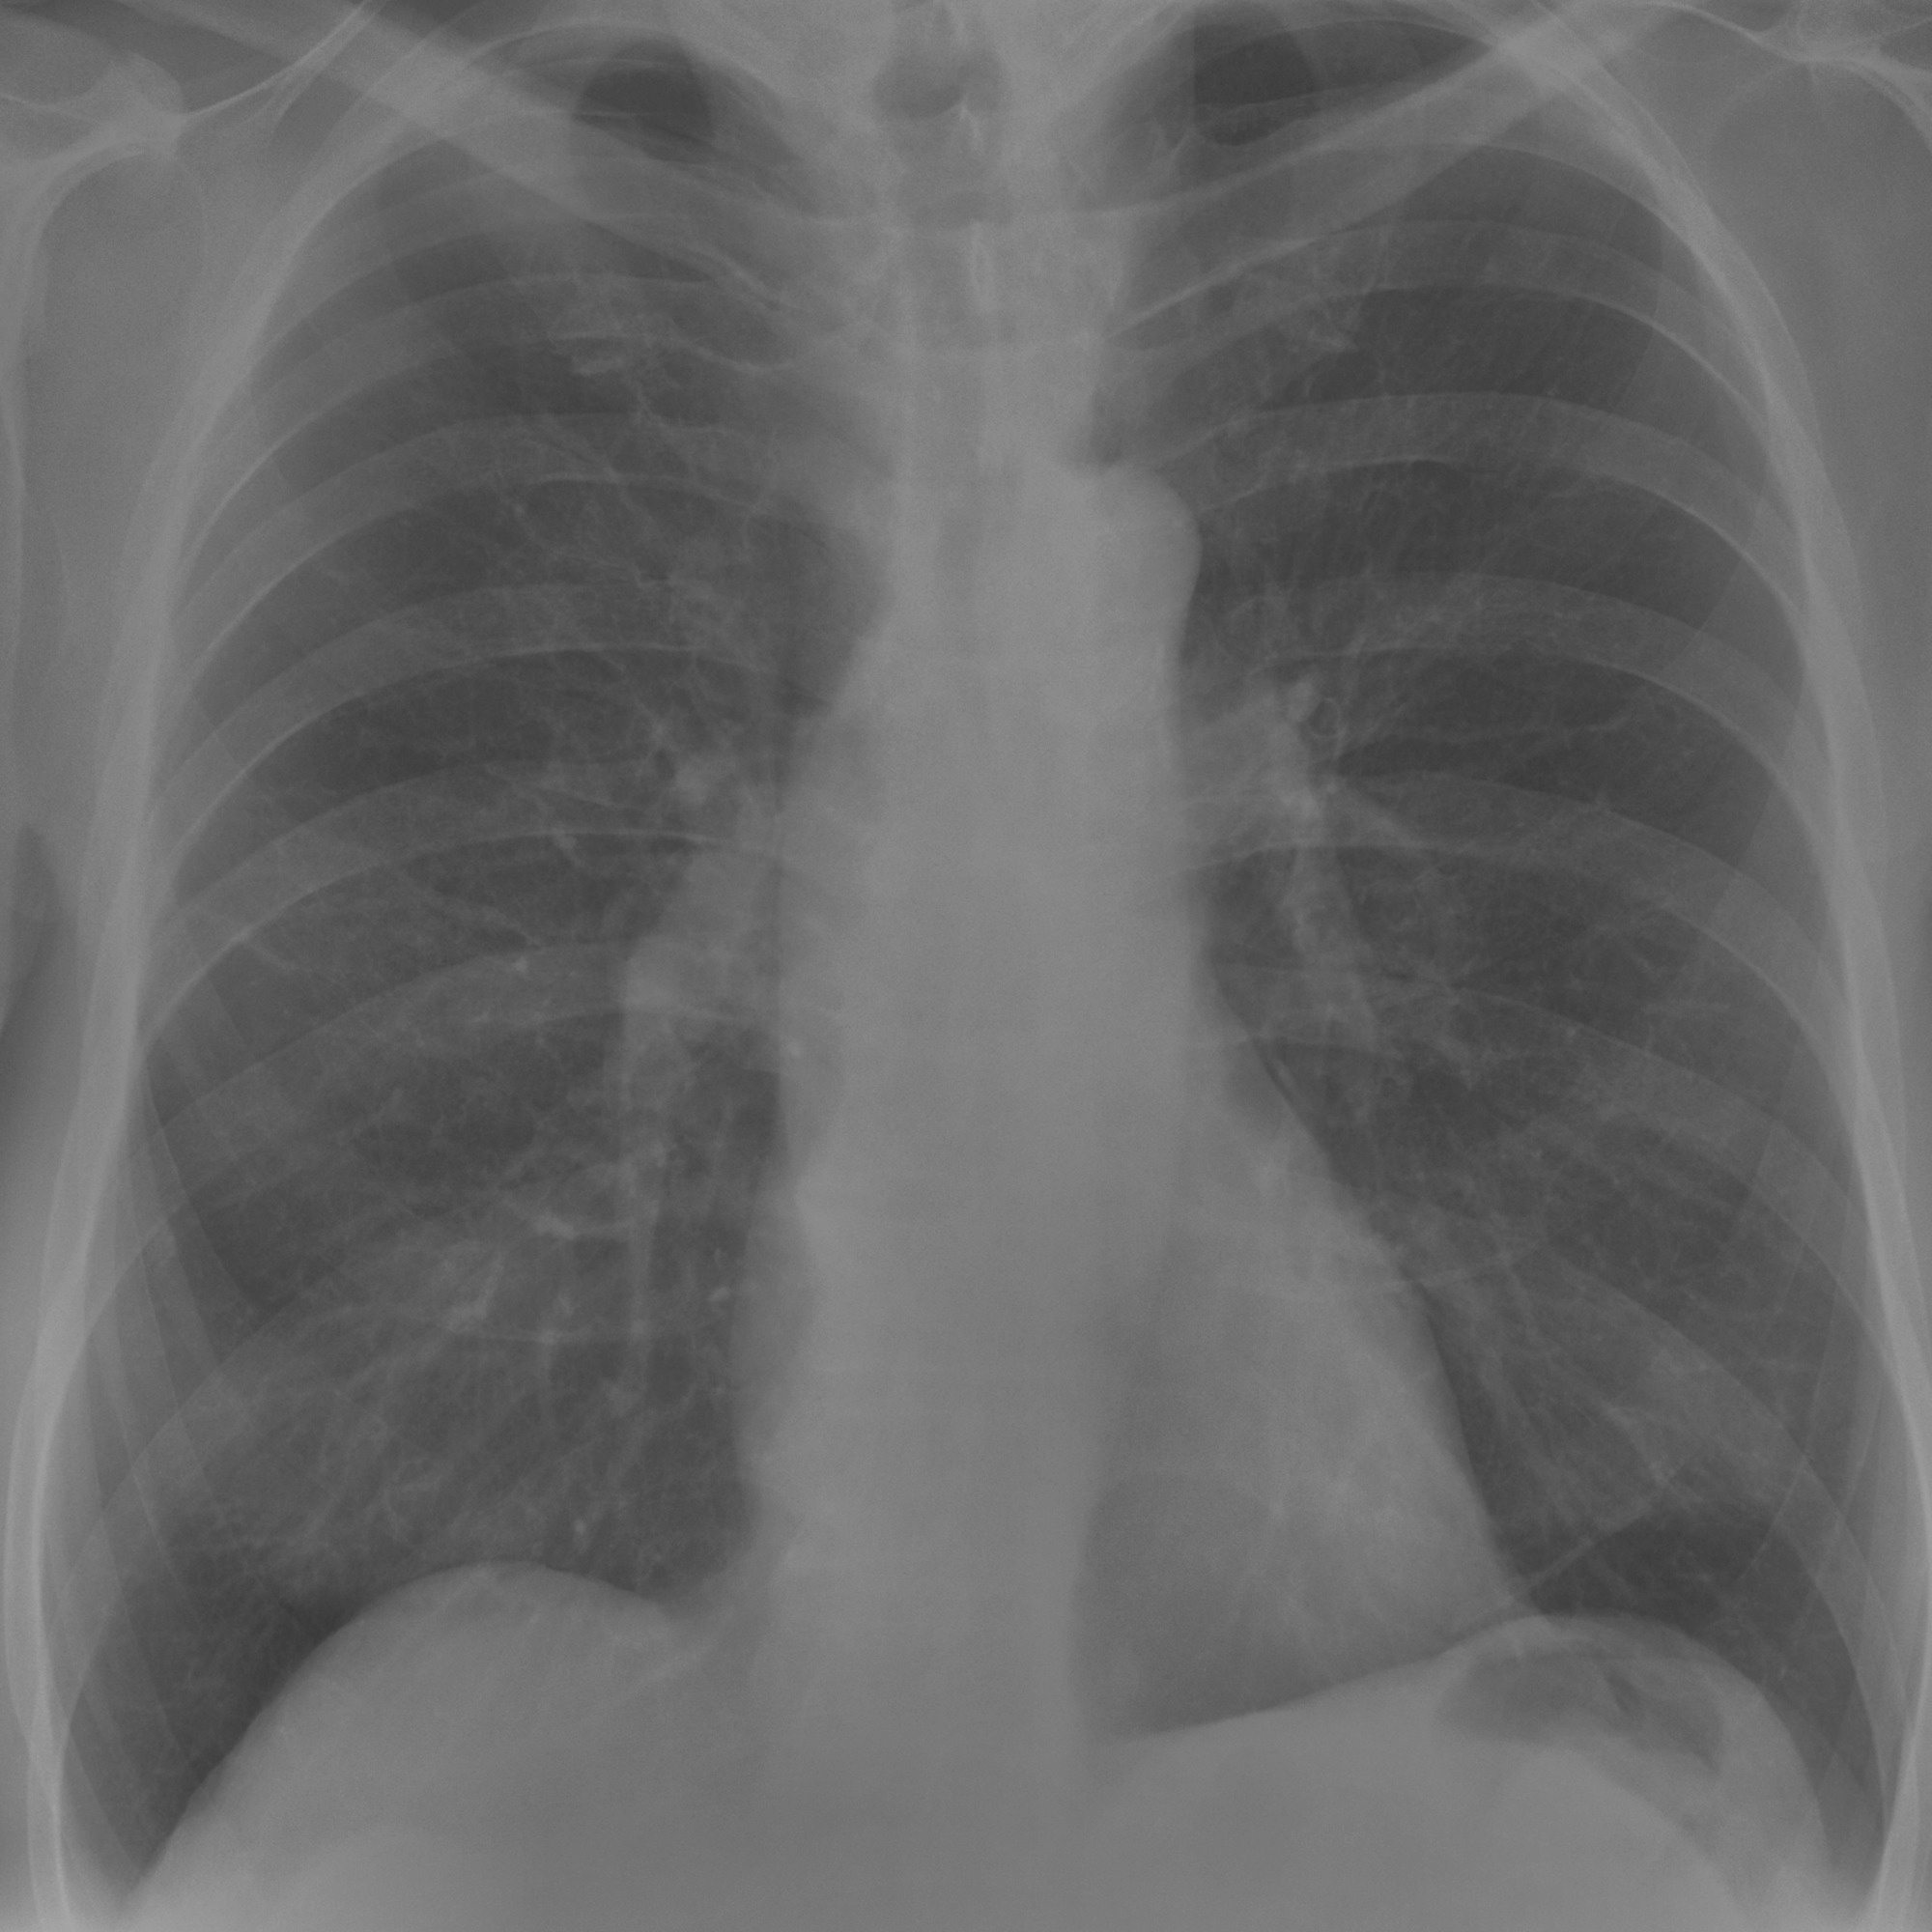

In [46]:
image

In [47]:
gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
resized=cv2.resize(gray,(100,100))
x = img_to_array(resized)
x = x.reshape((1,) + x.shape)# a Numpy array with shape (1, 3, 150, 150)

In [48]:
predict_x=model.predict(x) 
classes_x=np.argmax(predict_x,axis=1)

In [49]:
z=np.array(model(x))
z[0][0]

0.0

In [50]:
if (z[0][0]==0):
    print ("It is a Covid19 Negative")
else:
    print ("It is a Covid19 Positive")

It is a Covid19 Negative


In [51]:
import cv2
from tensorflow.keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
im = cv2.imread('F:/data_science/deep learning/DL All Content/Covid-19 prediction using X-Ray images -20201119T072858Z-001/Covid-19 prediction using X-Ray images/dataset1/Covid19 Negative/16691_1_1.jpg')  # this is a PIL image
#img=cv2.imread(img_path)

gray=cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
resized=cv2.resize(gray,(100,100))
x1 = img_to_array(resized)
x2 = x1.reshape((1,) + x1.shape)# a Numpy array with shape (1, 3, 150, 150)

In [52]:
predict_x=model.predict(x2) 
classes_x=np.argmax(predict_x,axis=1)

In [53]:
z=np.array(model(x2))
#z[0][0]

In [54]:
if (z[0][0]==0):
    print ("It is a Covid19 Negative")
else:
    print ("It is a Covid19 Positive")

It is a Covid19 Negative


In [55]:
print(model.evaluate(test_data,test_target))

5/5 [==============================] - 5s 889ms/step - loss: 0.3571 - accuracy: 0.8750
[0.35713908076286316, 0.875]


In [56]:
from attention.attention import Attention

In [57]:
model.save('model1211.h5')

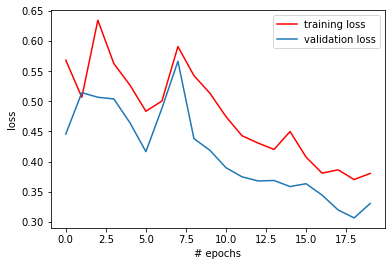

In [58]:
from matplotlib import pyplot as plt

plt.plot(history.history['loss'],'r',label='training loss')
plt.plot(history.history['val_loss'],label='validation loss')
plt.xlabel('# epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

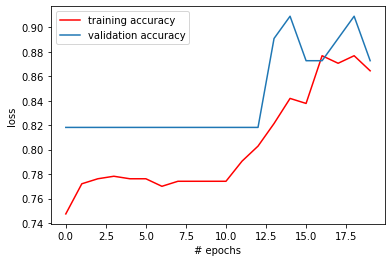

In [59]:
plt.plot(history.history['accuracy'],'r',label='training accuracy')
plt.plot(history.history['val_accuracy'],label='validation accuracy')
plt.xlabel('# epochs')
plt.ylabel('loss')
plt.legend()
plt.show()